In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("results.csv")

In [3]:
def context_diff_pivot_from_zero(df, value_col):
    """
    Context-to-context differences where the first column is value - 0
    Rows: Layer
    Columns: Context_Level
    """
    pivot = df.pivot(
        index="Layer",
        columns="Context_Level",
        values=value_col
    )

    pivot = pivot.sort_index(axis=1)

    diff = pivot.diff(axis=1)

    # Replace first column with value - 0
    first_col = diff.columns[0]
    diff[first_col] = pivot[first_col]

    return diff


In [4]:
def plot_diff_heatmap(data, title, fmt="+.2f", cmap="plasma"):
    plt.figure(figsize=(10, 6))

    vmax = np.nanmax(np.abs(data.values))

    im = plt.imshow(
        data,
        aspect="auto",
        origin="lower",
        cmap=cmap,
        vmin=-vmax,
        vmax=vmax
    )

    plt.colorbar(im, label="Δ Accuracy (Context − Previous Context)")

    plt.xticks(
        np.arange(len(data.columns)),
        data.columns,
        rotation=45,
        ha="right"
    )
    plt.yticks(
        np.arange(len(data.index)),
        data.index
    )

    # Cell annotations
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data.iloc[i, j]
            if not pd.isna(val):
                plt.text(
                    j, i,
                    format(val, fmt),
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="white" if val < data.values.max() * 0.7 else "black"
                )

    plt.xlabel("Context Level")
    plt.ylabel("Layer")
    plt.title(title)
    plt.tight_layout()
    plt.show()


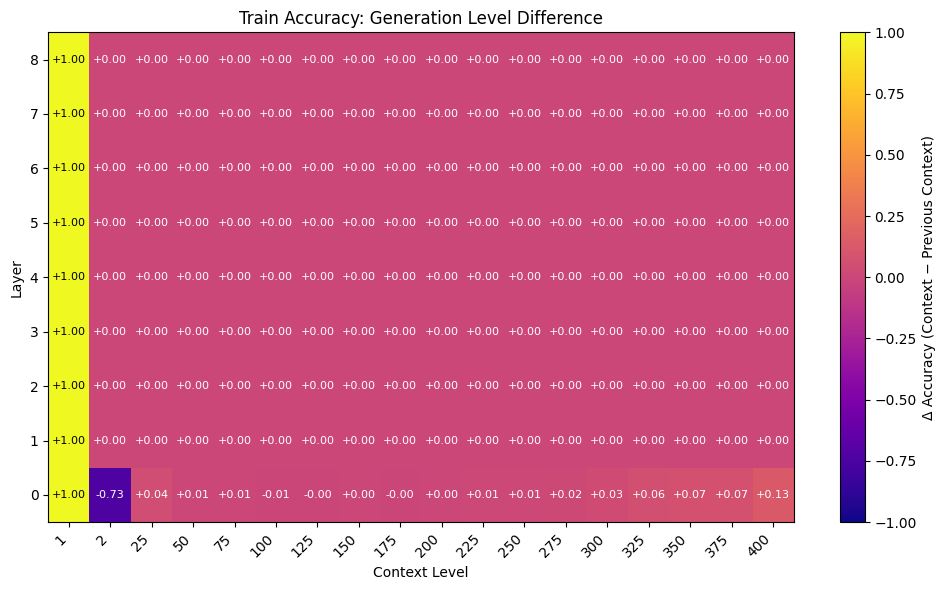

In [5]:
train_ctx_diff = context_diff_pivot_from_zero(df, "Train_Accuracy")
plot_diff_heatmap(
    train_ctx_diff,
    "Train Accuracy: Generation Level Difference"
)

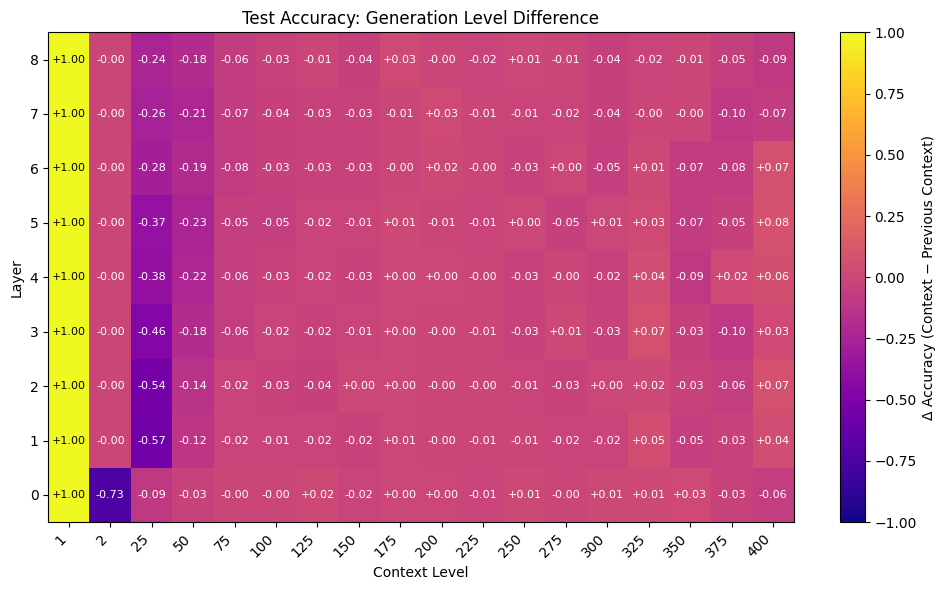

In [6]:
test_ctx_diff = context_diff_pivot_from_zero(df, "Test_Accuracy")
plot_diff_heatmap(
    test_ctx_diff,
    "Test Accuracy: Generation Level Difference"
)

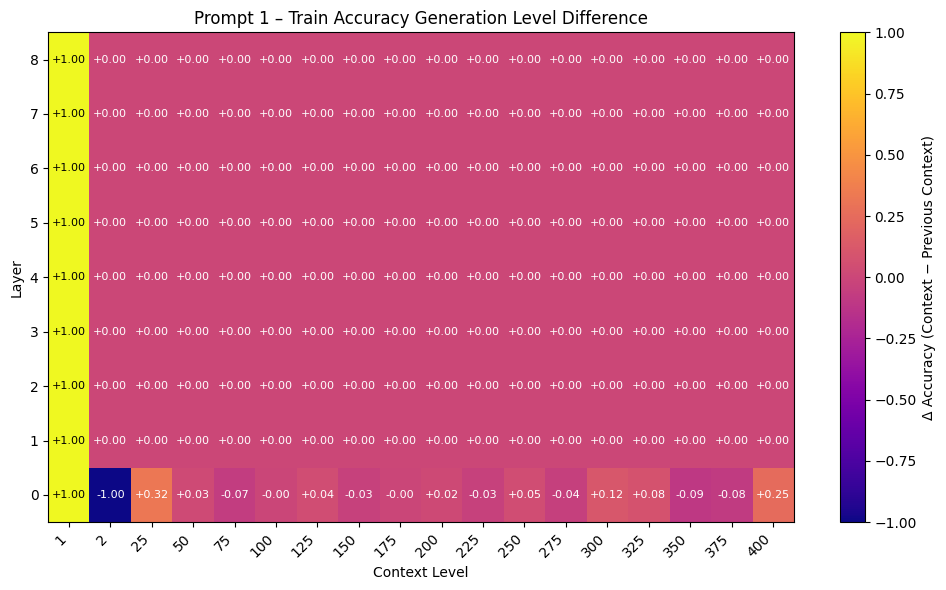

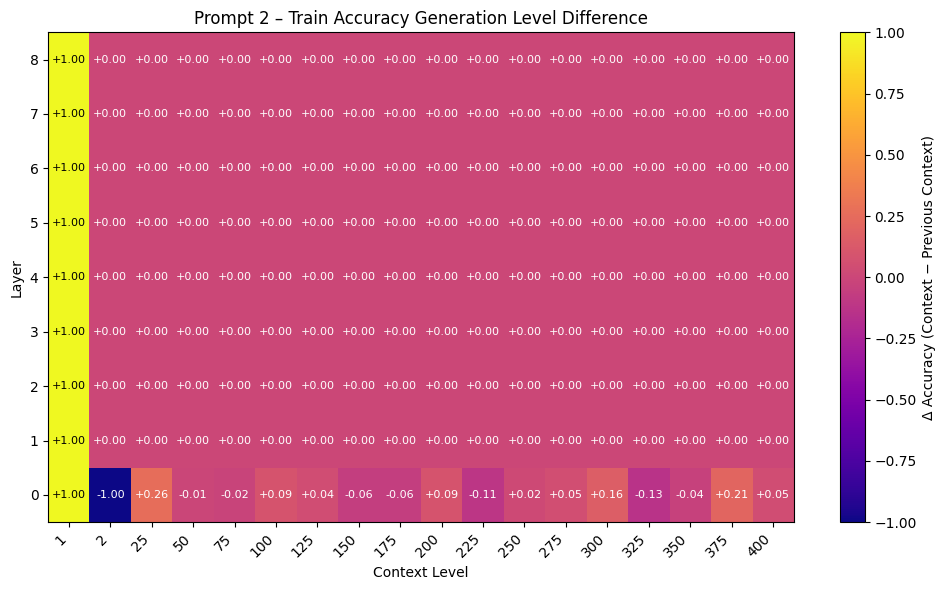

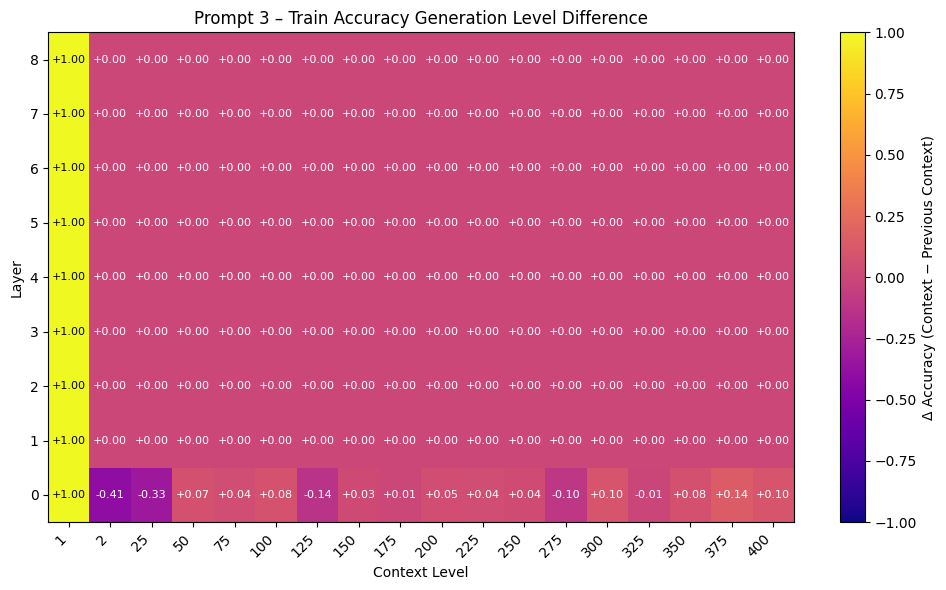

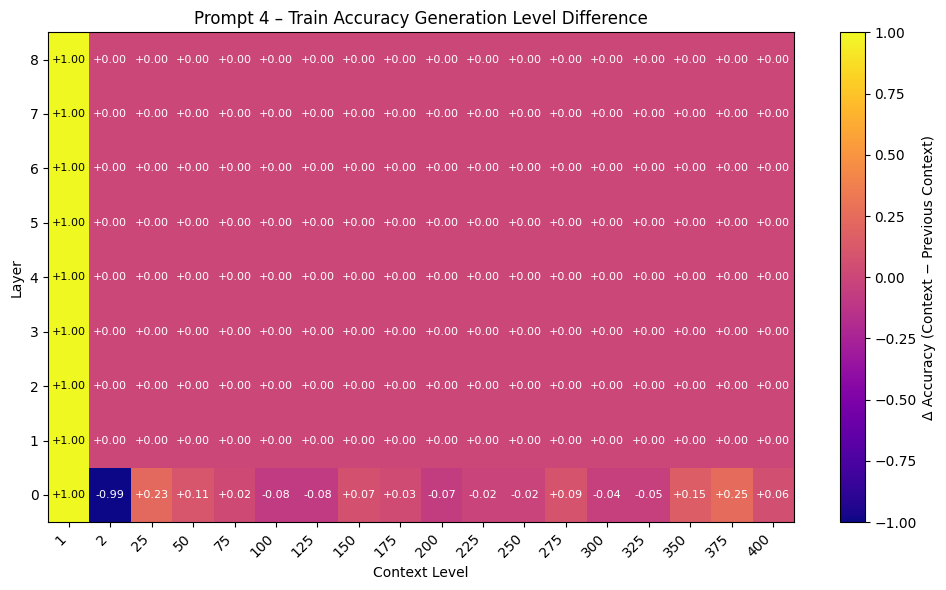

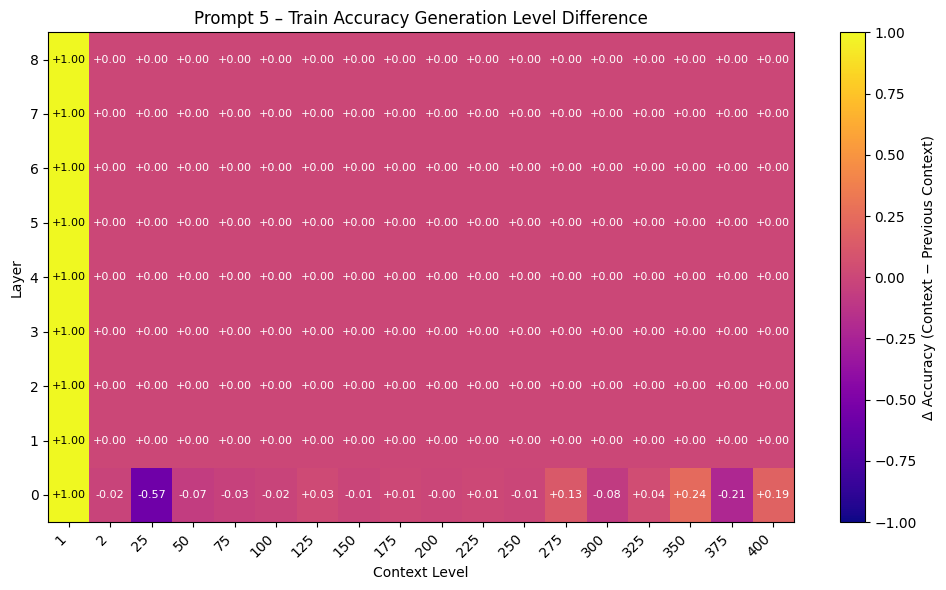

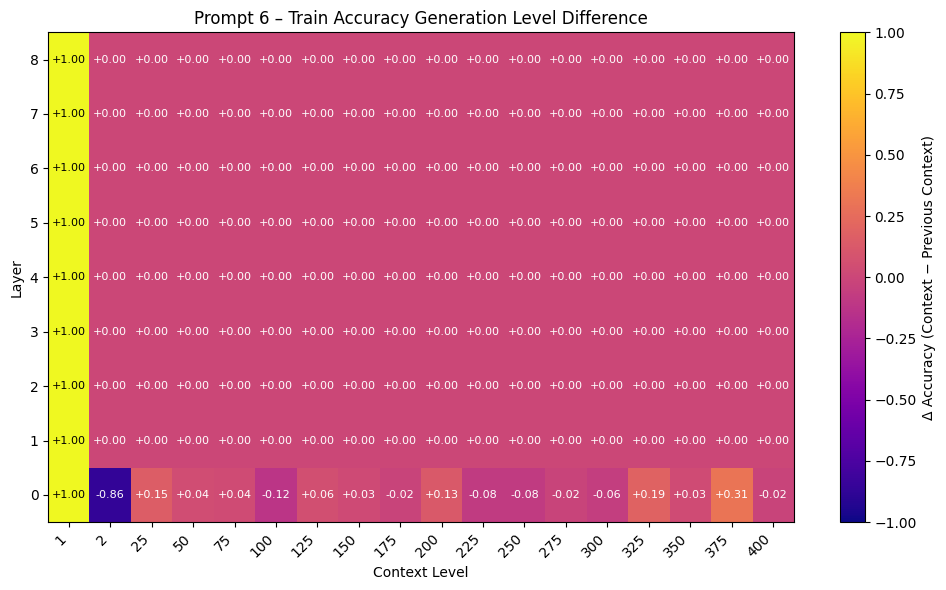

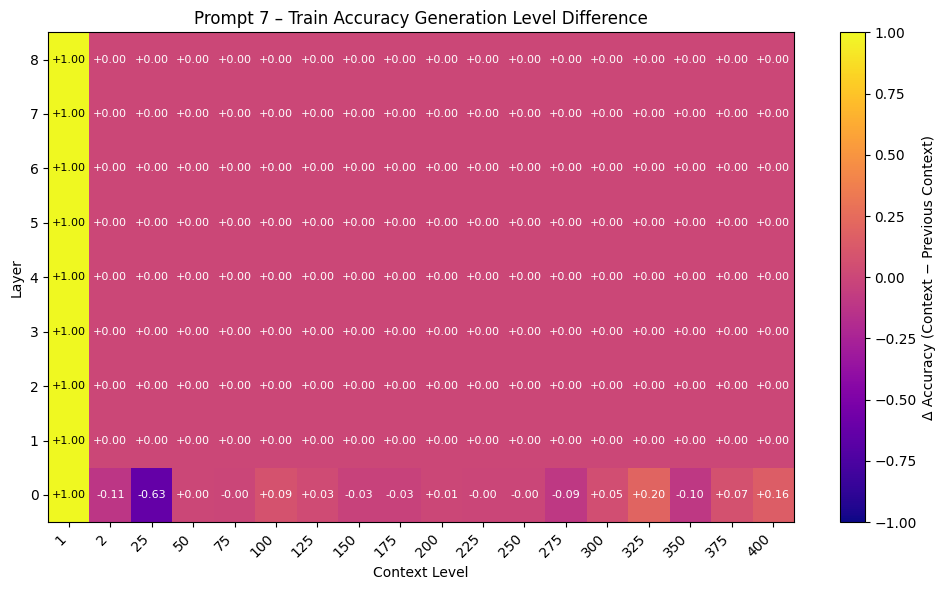

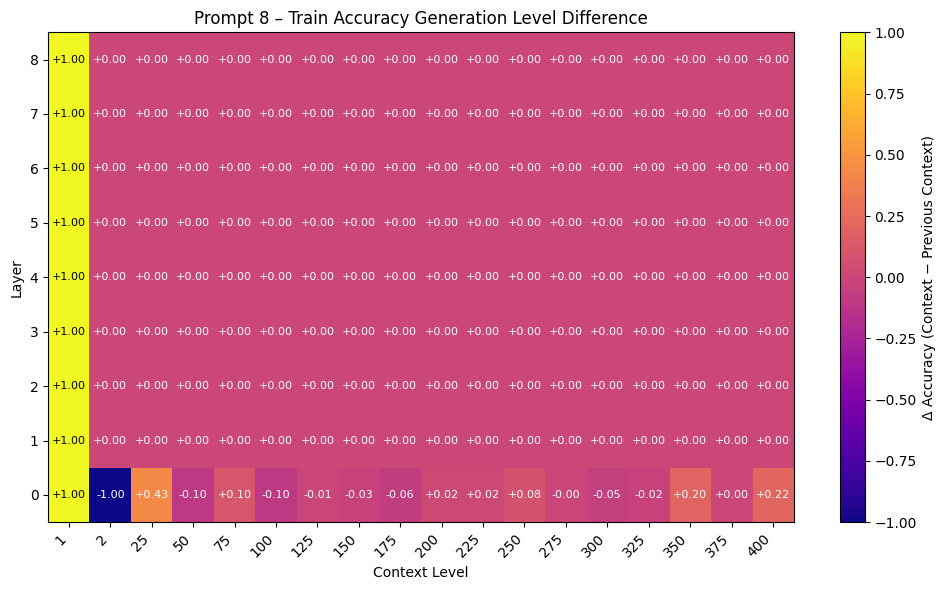

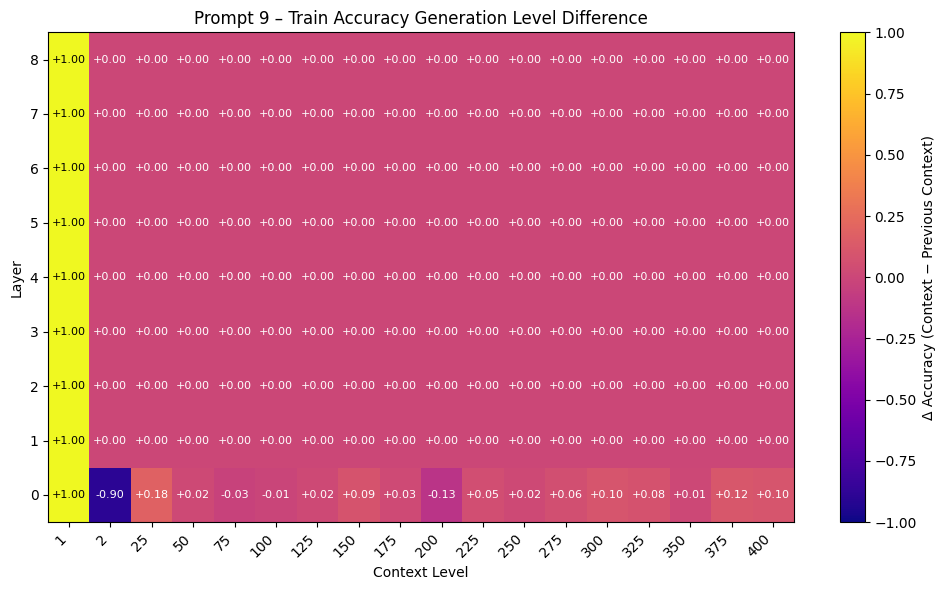

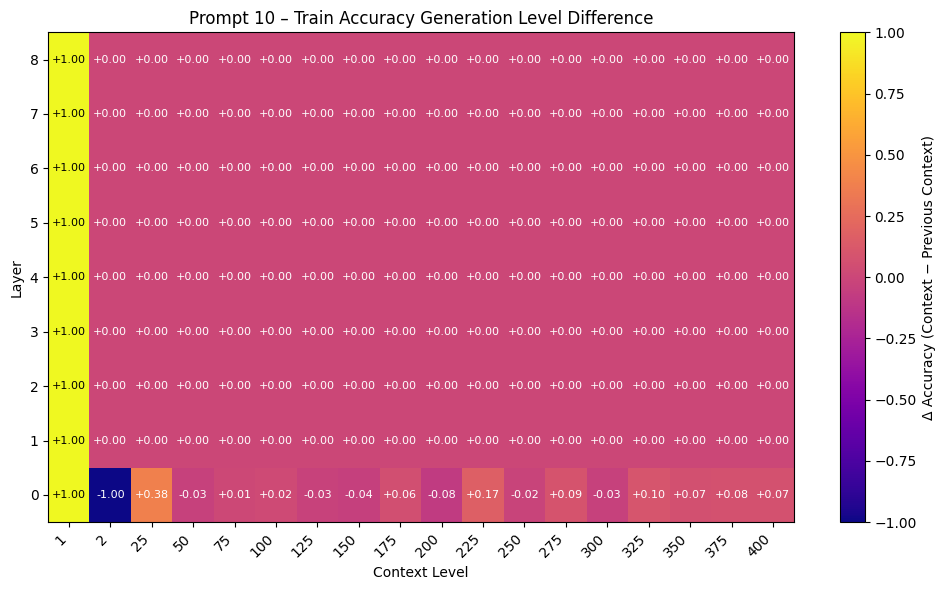

In [7]:
train_prompt_cols = [
    c for c in df.columns
    if c.startswith("Prompt") and c.endswith("_Train_Accuracy")
]

for col in train_prompt_cols:
    prompt_id = col.split("_")[1]

    diff = context_diff_pivot_from_zero(df, col)
    plot_diff_heatmap(
        diff,
        f"Prompt {prompt_id} – Train Accuracy Generation Level Difference"
    )

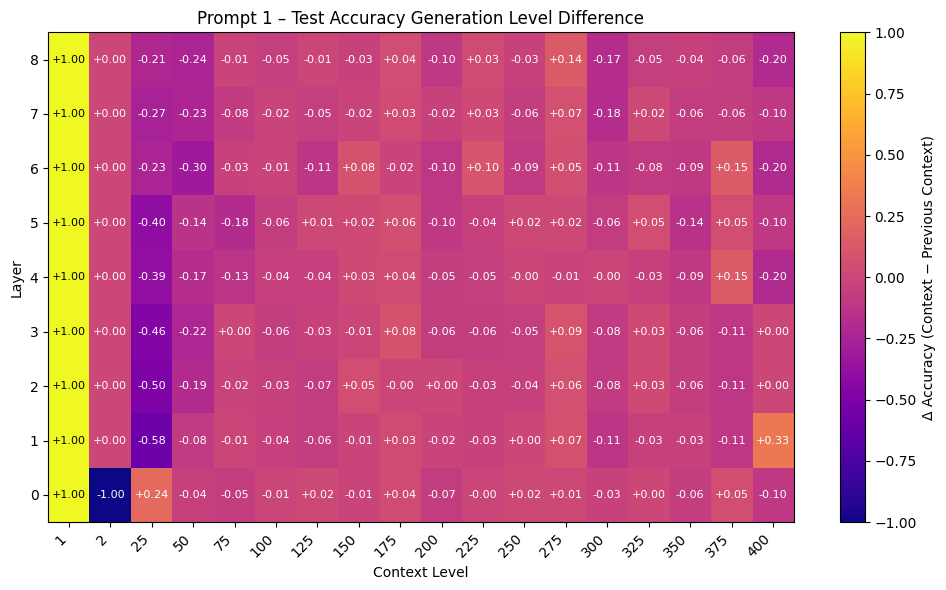

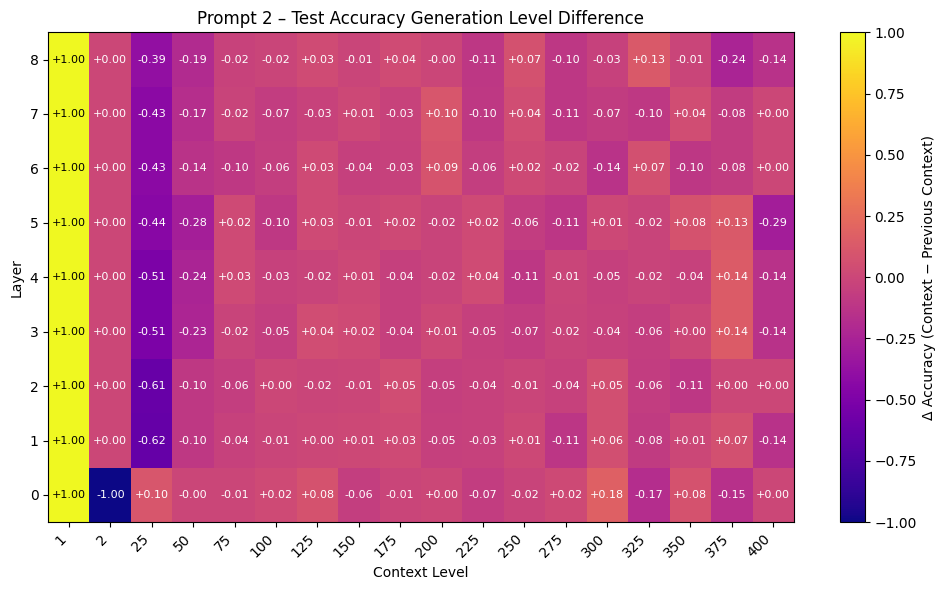

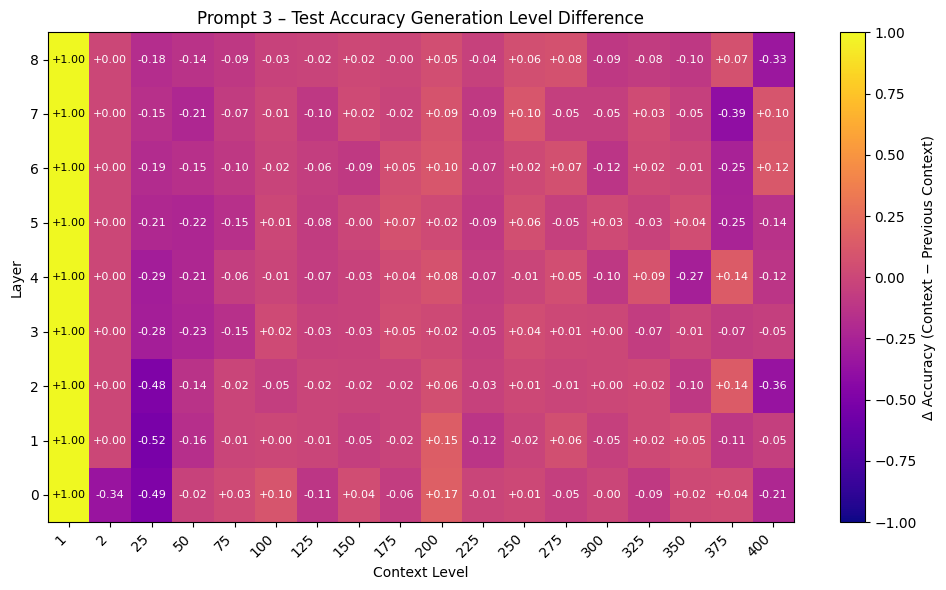

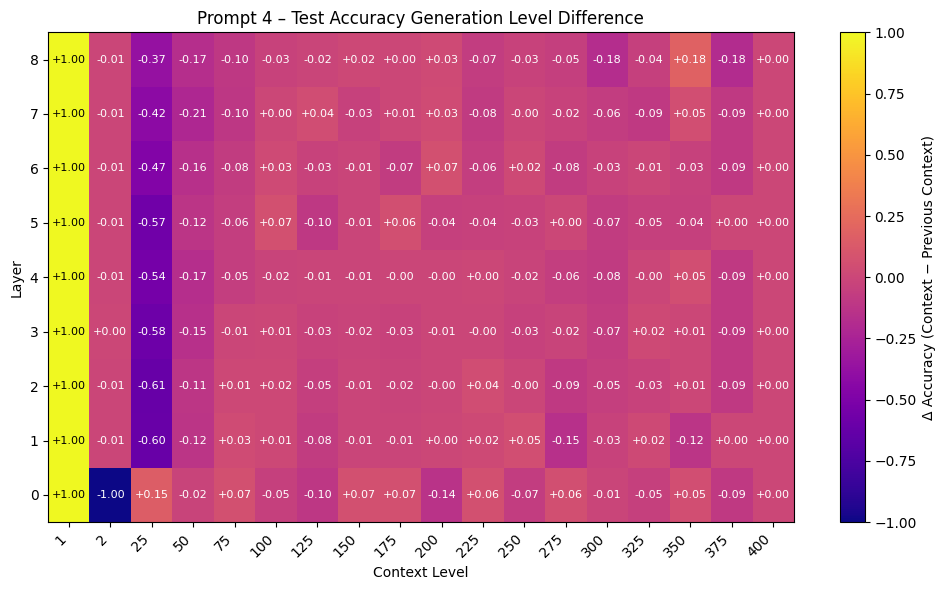

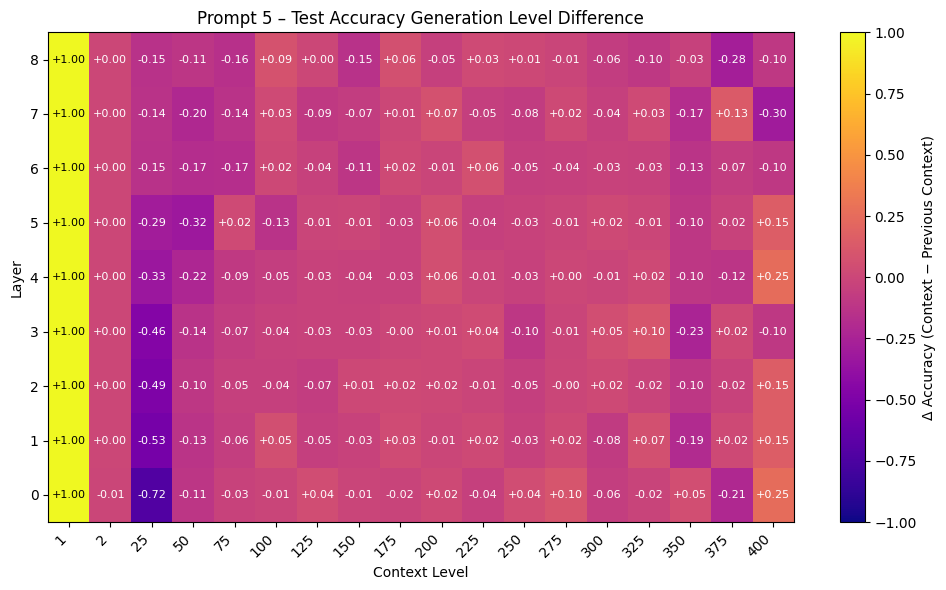

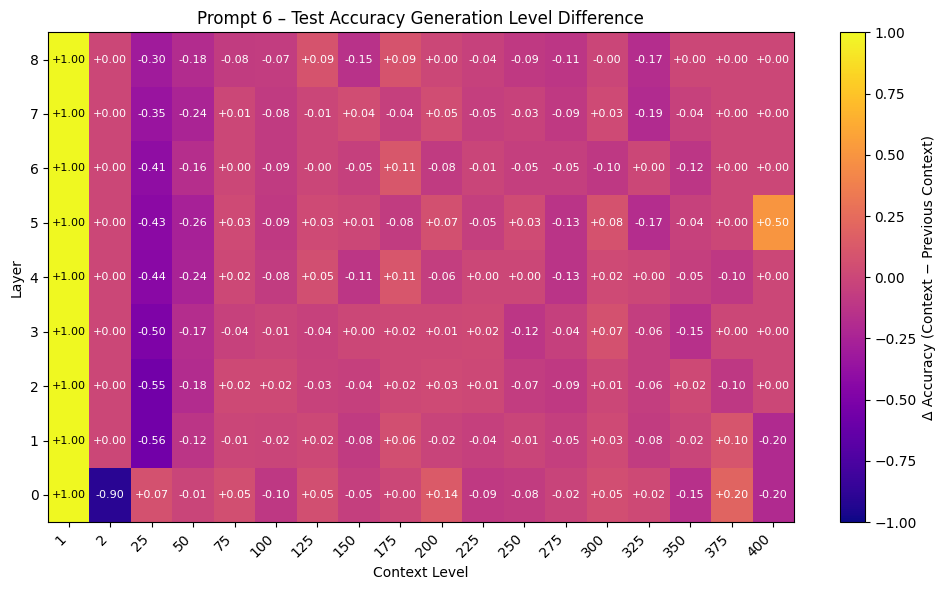

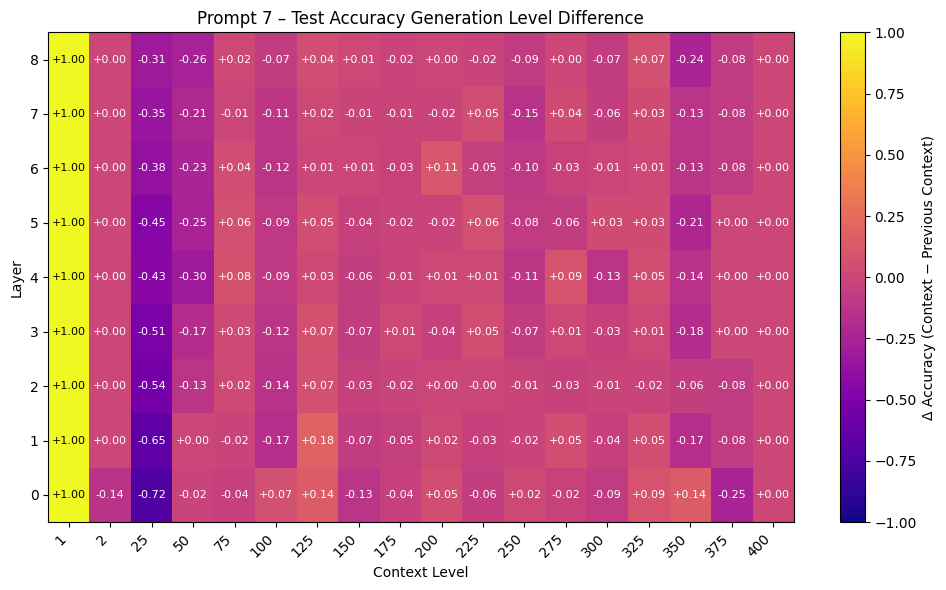

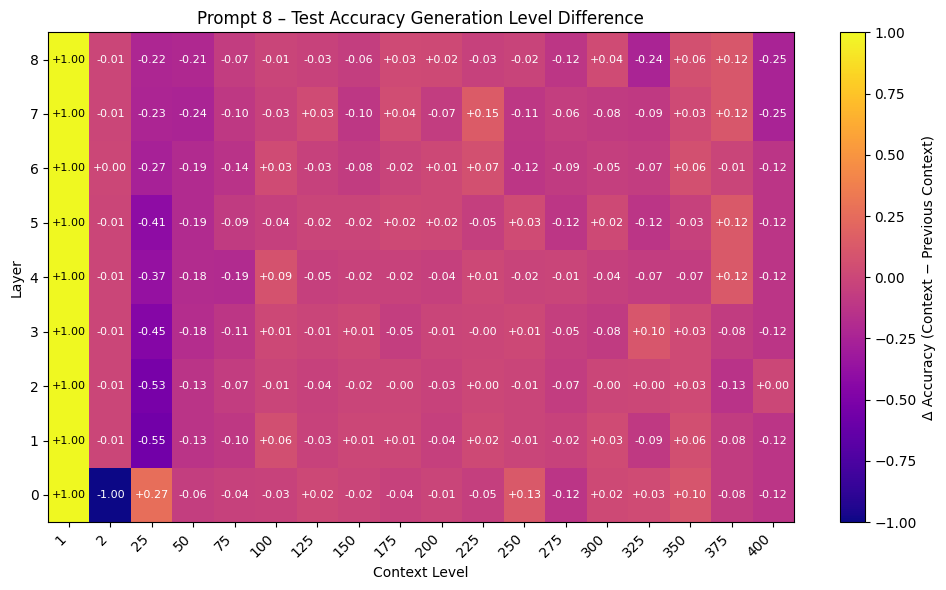

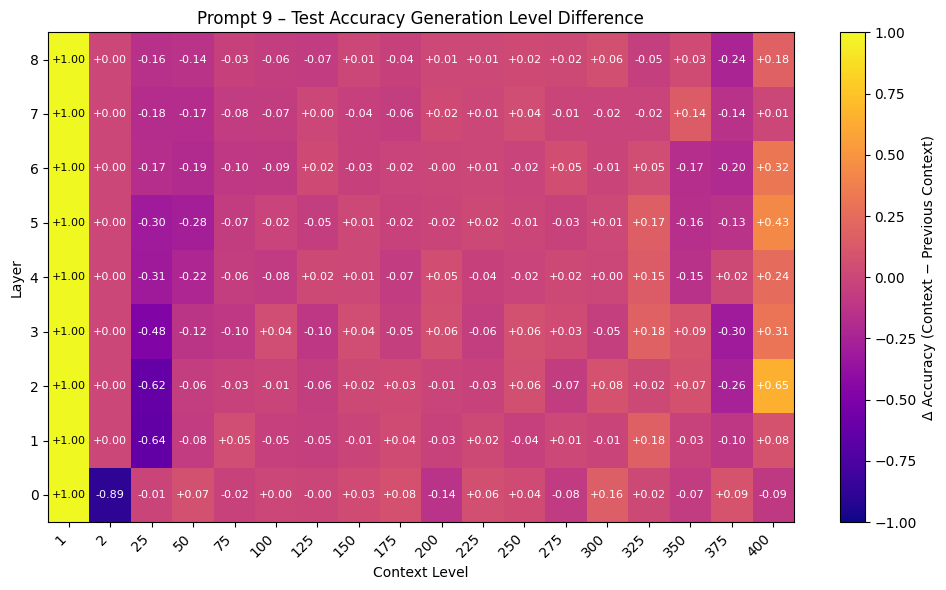

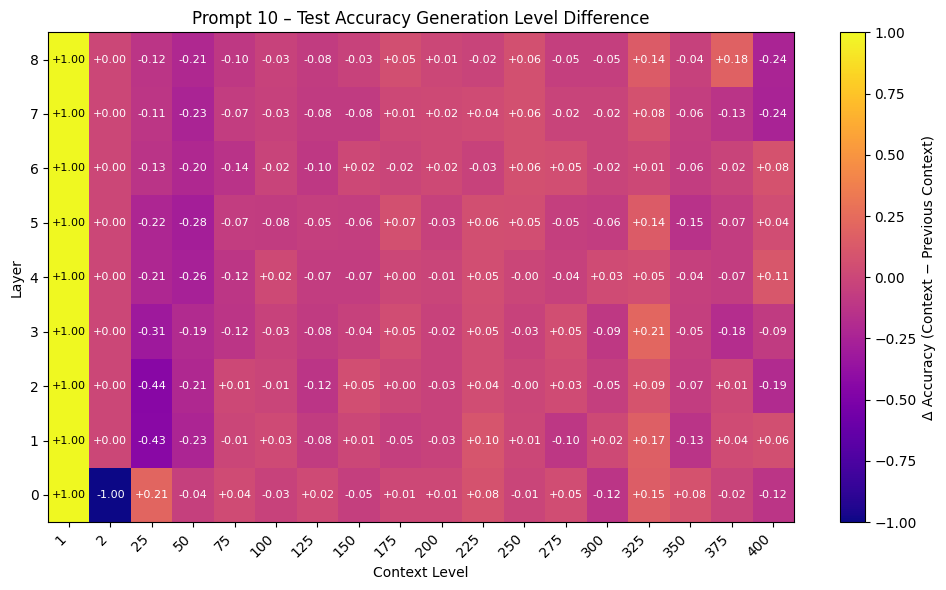

In [8]:
test_prompt_cols = [
    c for c in df.columns
    if c.startswith("Prompt") and c.endswith("_Test_Accuracy")
]

for col in test_prompt_cols:
    prompt_id = col.split("_")[1]

    diff = context_diff_pivot_from_zero(df, col)
    plot_diff_heatmap(
        diff,
        f"Prompt {prompt_id} – Test Accuracy Generation Level Difference"
    )

In [21]:
# How much info has been lost or gained from the previous generation level
# How much accuracy/info has been gained/lost from the previous layer.

def plot_avg_layer_diff(avg_diff, title, fmt="+.2f"):
    plt.figure(figsize=(8, 5))

    plt.bar(avg_diff.index, avg_diff.values)
    plt.axhline(0, color="black", linewidth=1)

    for x, y in zip(avg_diff.index, avg_diff.values):
        plt.text(
            x, y,
            format(y, fmt),
            ha="center",
            va="bottom" if y >= 0 else "top",
            fontsize=8
        )

    plt.xlabel("Layer")
    plt.ylabel("Avg Δ Accuracy (across Context Levels)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [23]:
def plot_single_column_heatmap(avg_diff, title, fmt="+.2f", cmap="plasma"):
    """
    avg_diff: pd.Series indexed by Layer
    """
    data = avg_diff.to_frame(name="Avg Δ")

    plt.figure(figsize=(4, 6))

    vmax = np.nanmax(np.abs(data.values))

    im = plt.imshow(
        data,
        aspect="auto",
        origin="lower",
        cmap=cmap,
        vmin=-vmax,
        vmax=vmax
    )

    plt.colorbar(im, label="Avg Δ Accuracy (Layer − Previous Layer)")

    plt.xticks([0], ["Avg Δ"])
    plt.yticks(
        np.arange(len(data.index)),
        data.index
    )

    # Annotate cells
    for i in range(data.shape[0]):
        val = data.iloc[i, 0]
        if not pd.isna(val):
            plt.text(
                0, i,
                format(val, fmt),
                ha="center",
                va="center",
                fontsize=9,
                color="white" if abs(val) < vmax * 0.7 else "black"
            )

    plt.xlabel("")
    plt.ylabel("Layer")
    plt.title(title)
    plt.tight_layout()
    plt.show()


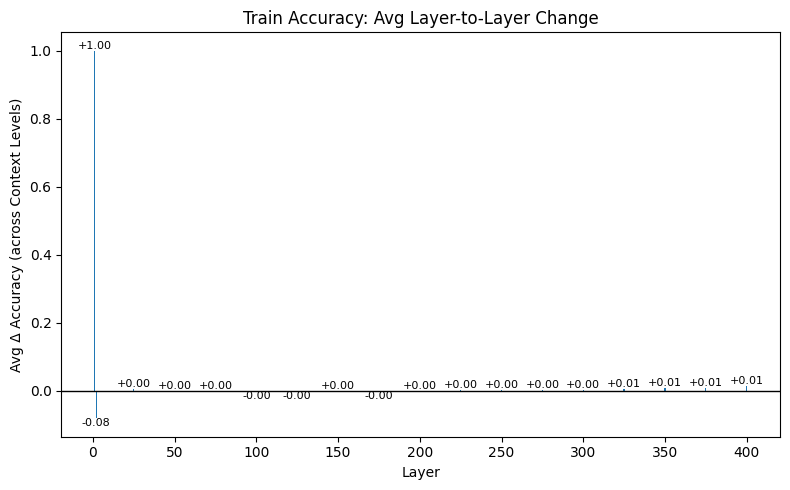

In [22]:
train_diff = context_diff_pivot_from_zero(df, "Train_Accuracy")
train_avg_diff = train_diff.mean(axis=0)

plot_avg_layer_diff(
    train_avg_diff,
    "Train Accuracy: Avg Layer-to-Layer Change"
)

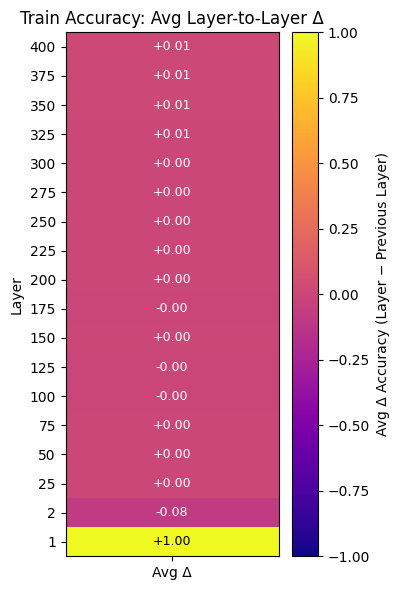

In [25]:
train_diff = context_diff_pivot_from_zero(df, "Train_Accuracy")
train_avg_diff = train_diff.mean(axis=0)

plot_single_column_heatmap(
    train_avg_diff,
    "Train Accuracy: Avg Layer-to-Layer Δ"
)


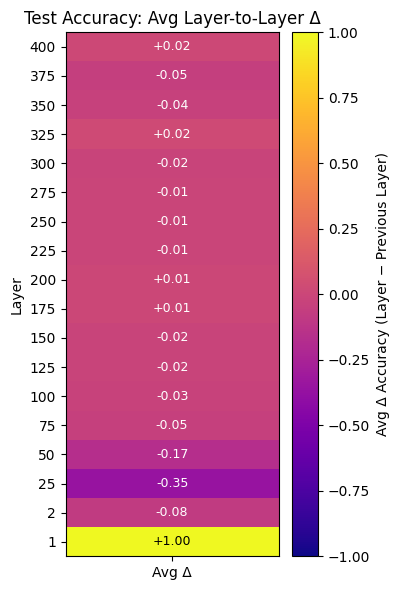

In [27]:
test_diff = context_diff_pivot_from_zero(df, "Test_Accuracy")
test_avg_diff = test_diff.mean(axis=0)

plot_single_column_heatmap(
    test_avg_diff,
    "Test Accuracy: Avg Layer-to-Layer Δ"
)


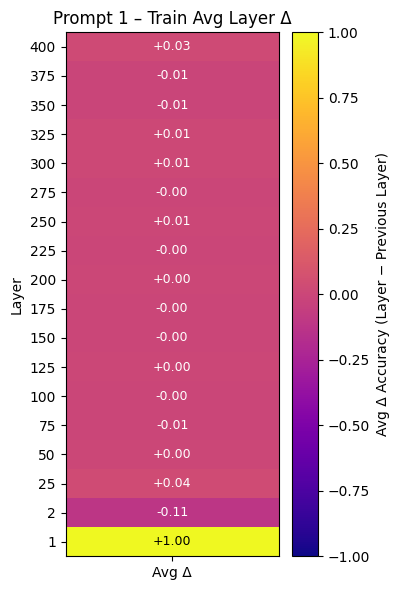

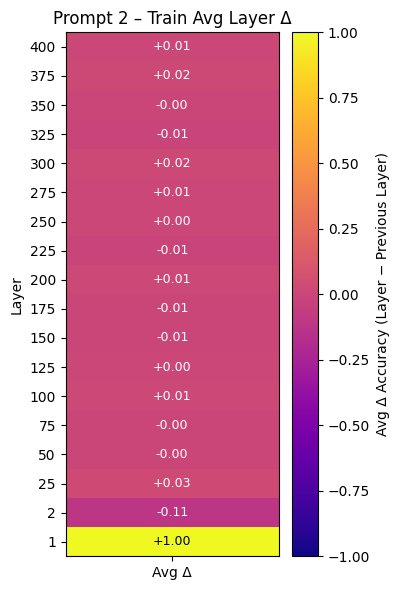

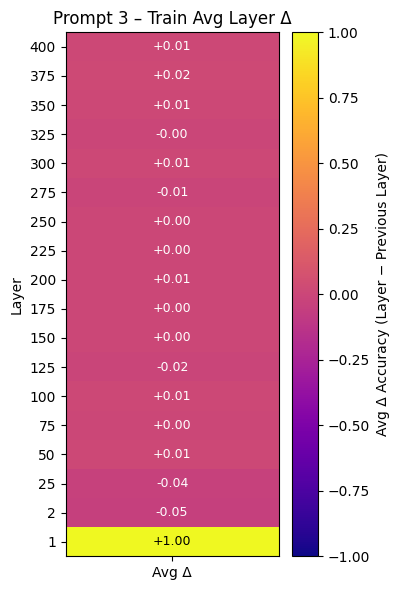

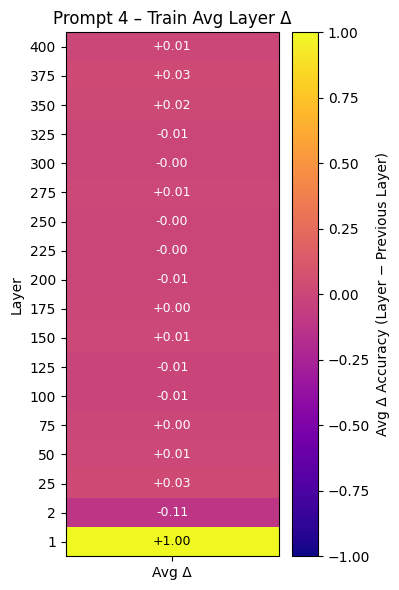

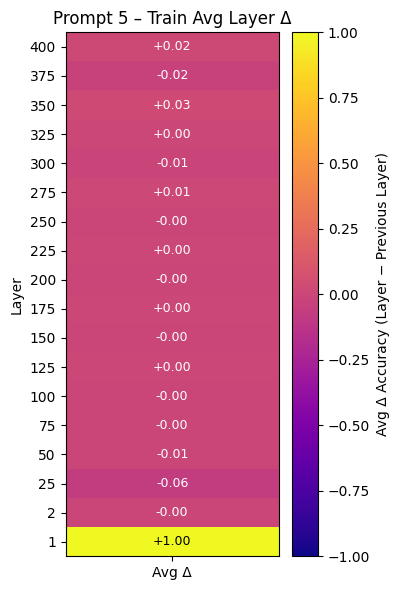

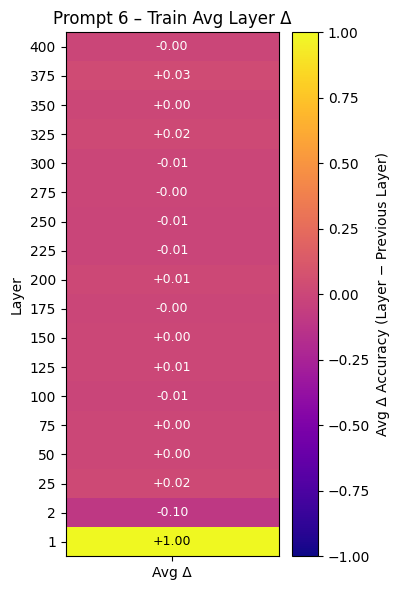

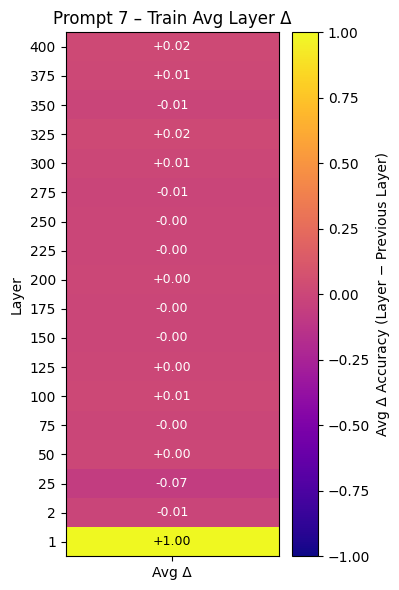

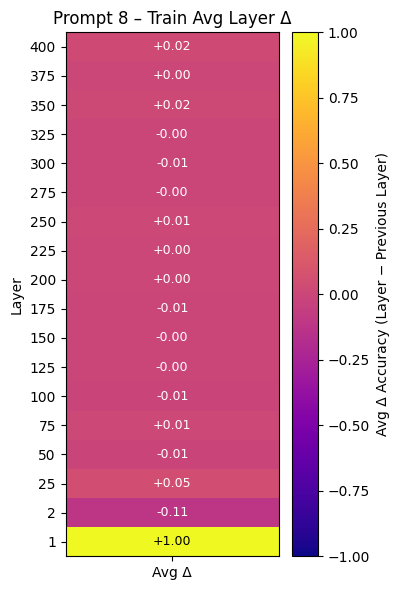

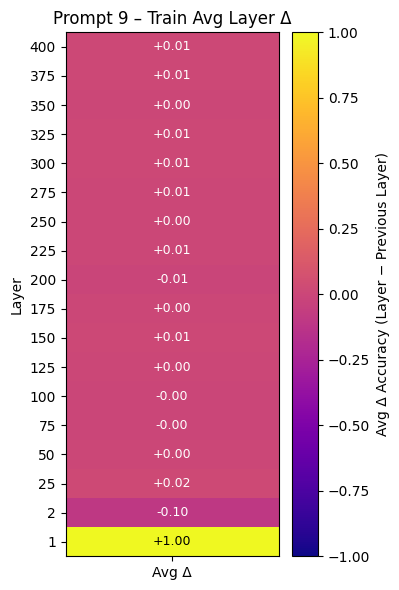

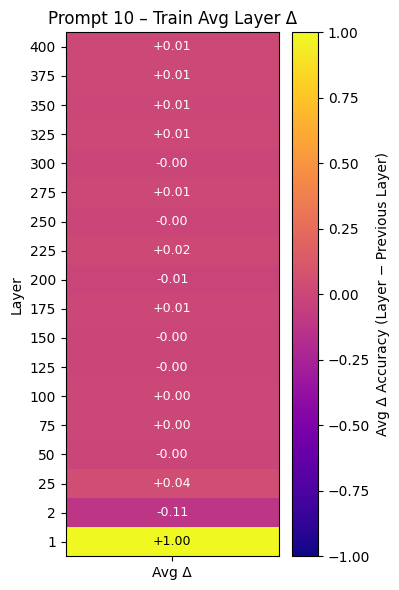

In [28]:
for col in train_prompt_cols:
    prompt_id = col.split("_")[1]

    diff = context_diff_pivot_from_zero(df, col)
    avg_diff = diff.mean(axis=0)

    plot_single_column_heatmap(
        avg_diff,
        f"Prompt {prompt_id} – Train Avg Layer Δ"
    )


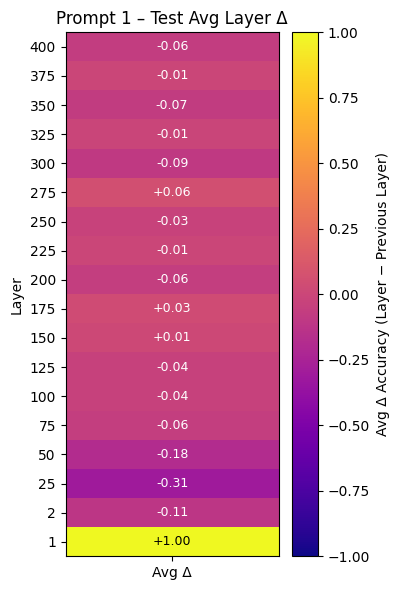

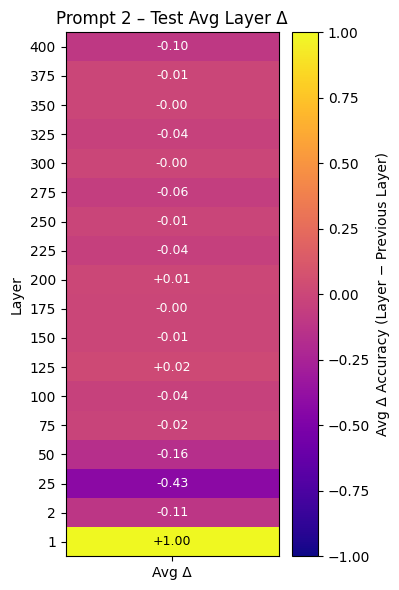

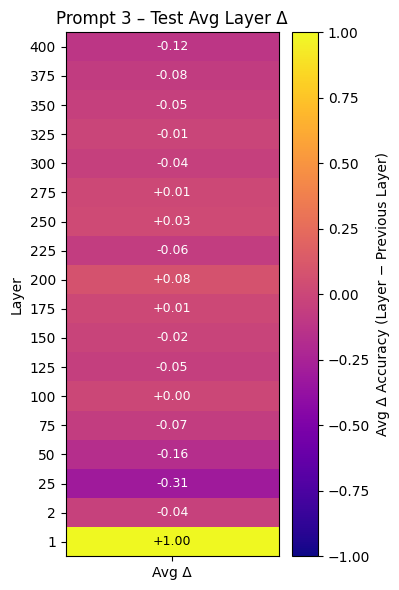

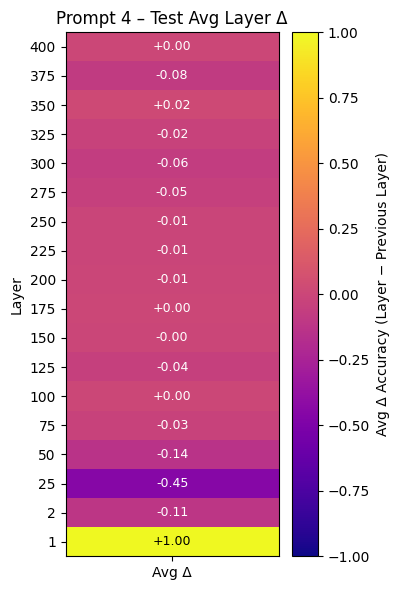

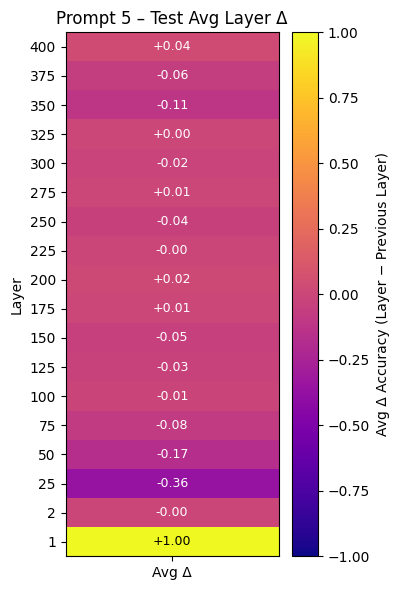

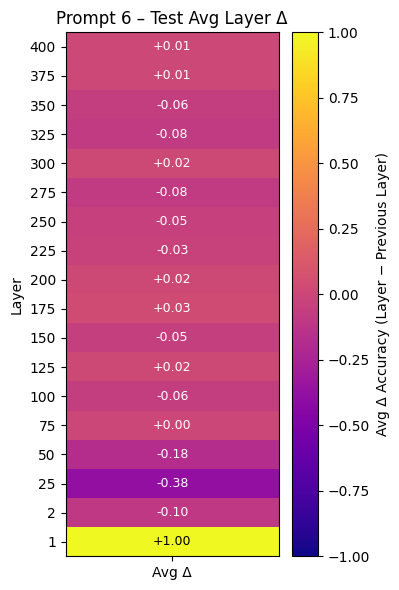

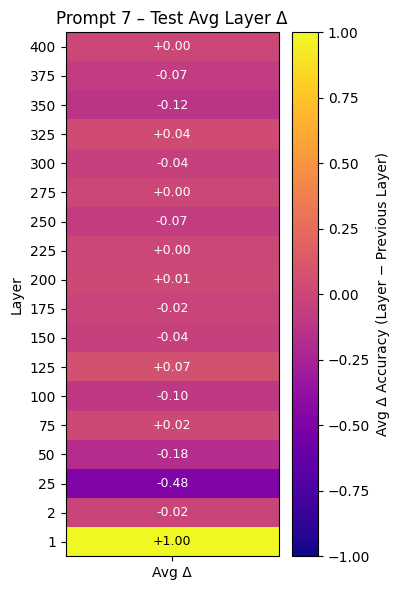

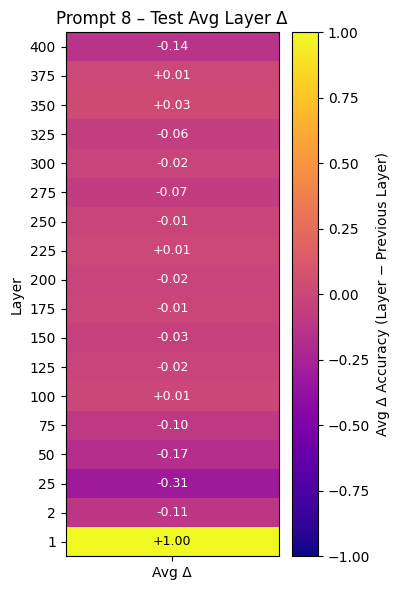

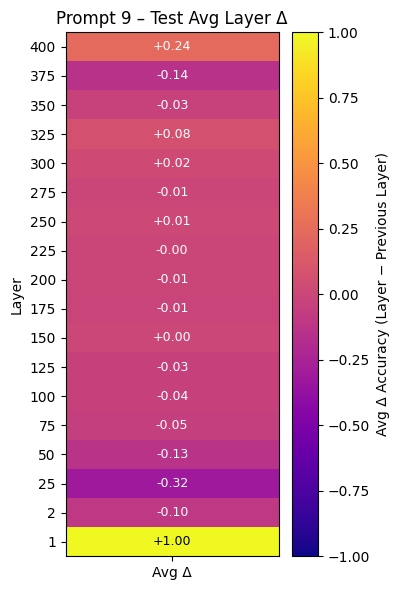

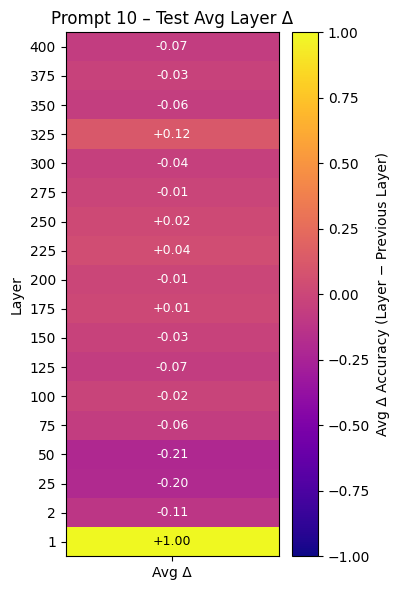

In [29]:
for col in test_prompt_cols:
    prompt_id = col.split("_")[1]

    diff = context_diff_pivot_from_zero(df, col)
    avg_diff = diff.mean(axis=0)

    plot_single_column_heatmap(
        avg_diff,
        f"Prompt {prompt_id} – Test Avg Layer Δ"
    )
